# THE STANFORDOPEN POLICINGPROJECT part 3

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.test.is_built_with_cuda()


True

In [3]:
print("num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

num GPUs Available:  1


In [4]:
print(tf.version.VERSION)

2.4.1


In [5]:
import sys
sys.version

'3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit (AMD64)]'

ต่อมาจาก part 2 จะเห็นว่าข้อมูลที่มีอยู่นั้น เป็น imbalance data คือ การตวรจค้นของตำรวจหลังจากยานพาหนะ ได้มีการเรียกให้หยุดโดยตำรวจ ไม่ได้มีจำนวนการเกิดขึ้นมากพอที่จะเทียบเท่ากับ การไม่ได้ตวรจค้นภายในยานพาหนะ พูดง่ายๆ ว่า ค้นภายในรถบางคันเท่านั้น รถที่ถูกเลือกที่ตรวจค้นจึงน้อยกว่ารถที่ไม่ถูกค้นเป็นจำนวนมาก

## จุดมุ่งหมายของการปรับปรุง Machine Learning model 
  

1. จัดการ imbalace data ในที่นี้เลือกใช้แบบไหนต้องลองดูกันว่าแบบไหนดีที่สุดจาก Random undersampling, Ensamble resampling, Class re-weight แต่ขอข้ามตัวที่เพิ่มข้อมูลที่เป็นการใช้ perfomance ของคอมพิวเตอร์สูงไปก่อนคือตัว Random oversampling และ SMOT (Synthetic Minority Oversampling Technique)

2. ทดลองกับ machine learning โดยใช้หลักการ Multi-Fidelity Search ทั้ง grid serch และ random search

3. ใช้ hyperband ช่วยในการ allocate resource เป็นการช่วยให้สามารถทำงานบนเครื่องคอมพิวเตอร์ที่ไม่ได้มี resource สูงมาก และประหยัดเวลากว่า gridsearch และ randomsearch

4. เลือกดูค่าการวัดผลที่สอดคล้องกับการใช้งานจริงจาก coufusion matrix ในที่นี้้ต้องดูค่า recall จาก Precision-Recal Curve แล้วดูค่า Area under Precision-Recall Curve (AUC of PR-curve) and Average Precision (AP) ประกอบด้วย

### "Although we already reduced the space of considered ML algorithmssubstantially compared to our previous Auto-sklearn (4 vs. 15 classifiers), we could have reduced this set even further since, in the end, only XGBoost models ended up in the final ensembles for the challenge"

Feurer et al, PoSH auto-sklearn

จาก คำพูดข้างบนนี้ เราจึงไม่ได้ใช้ AUTO ML แต่เลือกที่จะใช้ XGBoost models หลังจากจัดการกับ imbalance data

[XGBoost Python Package](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

# เริ่มสร้าง Machine learning model กันเลยครับ

  กำหนดตัวผลลัพท์จาก model ที่เราต้องการ
ขั้นแรก เราต้องการให้ผลลัพท์คือ ค่า y_pred (ค่าการทำนายจาก model) จากข้อมูลของการปฏิบัติงานของตำรวจใน Rhode Island ที่เกิดขึ้นจริงและเก็บ record ไว้ ในครั้งนี้จะมาสนใจในการทำ model ว่าจากพื้นฐานข้อมูลที่มีอยู่นี้ลักษณะการปฏิบัติงานของตำรวจส่งผลต่อการ ตรวจค้นยานพาหนะในท้ายที่สุดหรือไม่ นั่นก็คือ เราให้ label ที่ต้องการจะ model บอกเราครับ เพราะฉะนั้น จากตารางที่เรามีข้างล่างจะเห็นว่า ควร drop เรื่องของการถูกจับกุมหลังตรวจค้นยานพาหนะทิ้งไปเนื่องจากเป็นผลที่เกิดหลังจากพบเจอสิ่งผิดกฏหมาย
<br>
<br>
  <b><U>ให้ label หรือผลลัพธ์ที่ต้องการจาก model ที่ได้คือ search_conducted ก็คือการตรวจค้นยานพาหนะ<b><u>

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

## Importing the dataset and prepare prior to model input

In [2]:
raw = pd.read_csv(r'C:\Users\t_tan\Documents\SWU Msc DataScience\DS511 DS\ProjectFinalDS511_110_115\FinalDS SWU 631130110\PoliceRI2020cleaned.csv',index_col= "date_stop_time")

In [3]:
raw.head()

,district,driver_race,driver_gender,arrest_made,citation_issued,warning_issued,contraband_drugs,contraband_weapons,contraband_alcohol,frisk_performed,search_conducted,reason_for_stop
date_stop_time,,,,,,,,,,,,
2005-11-22 11:15:00,X3,white,male,False,True,False,False,False,False,False,False,Speeding
2005-10-01 12:20:00,X3,white,male,False,True,False,False,False,False,False,False,Speeding
2005-10-01 12:30:00,X3,white,female,False,True,False,False,False,False,False,False,Speeding
2005-10-01 12:50:00,X3,white,male,False,True,False,False,False,False,False,False,Speeding
2005-10-01 13:10:00,X3,white,female,False,True,False,False,False,False,False,False,Speeding


## ทำการสลับให้ column ที่เป็น label ไปอยู่ท้ายสุดให้ง่ายต่อการเลือก column ในการทำงาน
  

ข้อมูลเป็นแบบตารางที่ทำการ clean มาเรียบร้อยแล้วแต่ยังต้องมีการจัดเรียงให้ง่ายต่อการป้อนเข้าสู่ model ของ ML: machine learning ต่อไป เราจะกำหนดจากจุดมุ่งหมายได้บน

In [4]:
raw.columns

Index(['district', 'driver_race', 'driver_gender', 'arrest_made',
       'citation_issued', 'warning_issued', 'contraband_drugs',
       'contraband_weapons', 'contraband_alcohol', 'frisk_performed',
       'search_conducted', 'reason_for_stop'],
      dtype='object')

In [5]:
raw = raw[['district', 'driver_race', 'driver_gender', 'arrest_made',
       'citation_issued', 'warning_issued', 'contraband_drugs',
       'contraband_weapons', 'contraband_alcohol', 'frisk_performed',
       'reason_for_stop', 'search_conducted']]
raw.head()

,district,driver_race,driver_gender,arrest_made,citation_issued,warning_issued,contraband_drugs,contraband_weapons,contraband_alcohol,frisk_performed,reason_for_stop,search_conducted
date_stop_time,,,,,,,,,,,,
2005-11-22 11:15:00,X3,white,male,False,True,False,False,False,False,False,Speeding,False
2005-10-01 12:20:00,X3,white,male,False,True,False,False,False,False,False,Speeding,False
2005-10-01 12:30:00,X3,white,female,False,True,False,False,False,False,False,Speeding,False
2005-10-01 12:50:00,X3,white,male,False,True,False,False,False,False,False,Speeding,False
2005-10-01 13:10:00,X3,white,female,False,True,False,False,False,False,False,Speeding,False


ต่อไป คือการทำการ drop column "arrest_made" ควร drop เรื่องของการถูกจับกุมหลังตรวจค้นยานพาหนะทิ้งไปเนื่องจากเป็นผลที่เกิดหลังจากพบเจอสิ่งผิดกฏหมายโดยใช้ code ดังนี้

In [6]:
raw.drop('arrest_made', axis=1, inplace= True)
raw.head()

,district,driver_race,driver_gender,citation_issued,warning_issued,contraband_drugs,contraband_weapons,contraband_alcohol,frisk_performed,reason_for_stop,search_conducted
date_stop_time,,,,,,,,,,,
2005-11-22 11:15:00,X3,white,male,True,False,False,False,False,False,Speeding,False
2005-10-01 12:20:00,X3,white,male,True,False,False,False,False,False,Speeding,False
2005-10-01 12:30:00,X3,white,female,True,False,False,False,False,False,Speeding,False
2005-10-01 12:50:00,X3,white,male,True,False,False,False,False,False,Speeding,False
2005-10-01 13:10:00,X3,white,female,True,False,False,False,False,False,Speeding,False


### ทดลองดึงข้อมูลออกมาดูจากแถวที่ 25 โดยไม่รวมเอา column ที่เป็น Label (ผลลัพธ์) ออกมาด้วย ว่าข้อมูลมีลักษณะอย่างไร

In [7]:
raw.iloc[25, :-1].values

array(['X3', 'white', 'male', True, False, False, False, False, False,
       'Speeding'], dtype=object)

## ทำการแบ่งชุดข้อมูลให้เป็นส่วนของการ train ของ model และ ส่วน Label ของ model

### Splitting the dataset into the Training set and Test set

In [8]:
X = raw.iloc[:, :-1].values
y = raw.iloc[:, -1].values
print("X :", X)
print("y :", y)
print("X shape :", X.shape)

X : [['X3' 'white' 'male' ... False False 'Speeding']
 ['X3' 'white' 'male' ... False False 'Speeding']
 ['X3' 'white' 'female' ... False False 'Speeding']
 ...
 ['K3' 'white' 'female' ... False False 'Speeding']
 ['X4' 'white' 'male' ... False False 'Equipment/Inspection Violation']
 ['X4' 'white' 'female' ... False False 'Speeding']]
y : [False False False ... False False False]
X shape : (480584, 10)


## Encoding the Independent Variable


### ขั้นตอนนี้เป็นการทำการแปลงข้อมูลของค่า X ที่เป็นข้อมูลไว้สำหรับเป็น Train Model โดยจะแปลงที่ column "district", "driver_race", "driver_gender",
"reason_for_stop" ที่เป็นข้อมูล Categorical Data ให้แตกเป็น Column ย่อย ๆ
และเก็บข้อมูลเป็นแบบ Binary (เก็บค่าที่เป็น 0 หรือ 1 เท่านั้น)

โดยปกติเราสามารถใช้ ฟังก์ชั่น getdummy() ได้ แต่ในที่นี้ขอใช้เป็น preprocessing ใน sklearn มาอำนวยความสะดวกในการทำ คือการใช้ ColumnTranformer และ
OneHotEncoder


และจะเห็นได้ว่าหลังจากผ่านกระบวนการนี้ ตัว feature ของค่า X จะมีขนาดเพิ่มจาก 10 เป็น 31 features

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1,2,9])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [10]:
print(X)
print(X.shape)

[[0.0 0.0 0.0 ... False False False]
 [0.0 0.0 0.0 ... False False False]
 [0.0 0.0 0.0 ... False False False]
 ...
 [0.0 0.0 1.0 ... False False False]
 [0.0 0.0 0.0 ... False False False]
 [0.0 0.0 0.0 ... False False False]]
(480584, 31)


ทดลองดึง row ที่ 25 เช่นเดิมเพื่อดูว่าข้อมูลเป็นอย่างไรหลังจากทำผ่านการใช้ OneHotencoder ลองนำไปเทียบกับ row ที่ 25  ที่เราดึงจากตารางก่อนผ่านกระบวนการดูได้

In [11]:
print(X[25])
print(X[25].shape)

[0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 1.0 0.0 0.0 0.0 True False False False False False]
(31,)


## Encoding the Dependent Variable

 ขั้นตอนนี้เป็นการทำการแปลงข้อมูลของค่า y ที่เป็นข้อมูลไว้สำหรับเป็น Label model จากเดิมเป็นค่า boolean คือ True, False ให้เป็นค่า Binary (คือ 0 และ 1) โดยที่ 0 คือการไม่โดนตรวจค้นยานพาหนะ และ 1 คือโดนตรวจค้นยานพาหนะ

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
print(y)
print(y.shape)

[0 0 0 ... 0 0 0]
(480584,)


 ทำการแยกส่วนของ Training set และ Test set ด้วยการใช้ ฟังก์ชั่น train_test_split ในที่นี้ใช้ test_size 20 เปอร์เซ็นต์ของข้อมูลที่มี 80 เปอร์เซ็นต์ใช้ในการ train model

และลอง print ค่าของ X_train, X_test , y_train, y_test ออกมาดู และ ขนาดของค่าต่างๆ ก็สำคัญ ไว้ดูว่า มี feature ที่ป้อนไปถูกต้องเท่ากันหรือไม่ เมื่อมีปัญหามาดูในภายหลังจะง่ายต่อการหาวิธีการแก้ไข

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y, test_size=0.20, random_state= 1)

In [15]:
print(X_train)
print("X_train shape :", X_train.shape)

[[0.0 0.0 1.0 ... False False False]
 [0.0 0.0 0.0 ... False False False]
 [0.0 0.0 0.0 ... False False False]
 ...
 [0.0 0.0 1.0 ... False False False]
 [0.0 1.0 0.0 ... False False False]
 [0.0 1.0 0.0 ... False False False]]
X_train shape : (384467, 31)


In [16]:
print(X_test)
print("X_test shape :", X_test.shape)

[[0.0 0.0 0.0 ... False False False]
 [0.0 0.0 0.0 ... False False False]
 [0.0 0.0 1.0 ... False False False]
 ...
 [0.0 0.0 0.0 ... False False False]
 [0.0 0.0 0.0 ... False False False]
 [0.0 1.0 0.0 ... False False False]]
X_test shape : (96117, 31)


In [17]:
print(y_train)
print("y_train shape :", y_train.shape)

[0 0 0 ... 0 0 0]
y_train shape : (384467,)


In [18]:
print(y_test)
print("y_test shape :", y_test.shape)

[0 0 0 ... 0 0 0]
y_test shape : (96117,)


จากขนาดของข้อมูลแต่ละคู่ จะเห็นว่าจำนวน row ของ ตัวข้อมูลที่คู่กันระหว่าง X_train และ y_train นั้นเท่ากัน เช่นเดียวกับคู่ของ X_test และ y_test 

## 1. จัดการ Imbalance Data ด้วยวิธีต่างๆดังนี้  


> Random undersampling

> Ensamble resampling  






> Class re-weight





Random Undersampling  
from picture blue is class 1 data(search_conduct)  and Red is class 0 (seach_conduct not occur) 

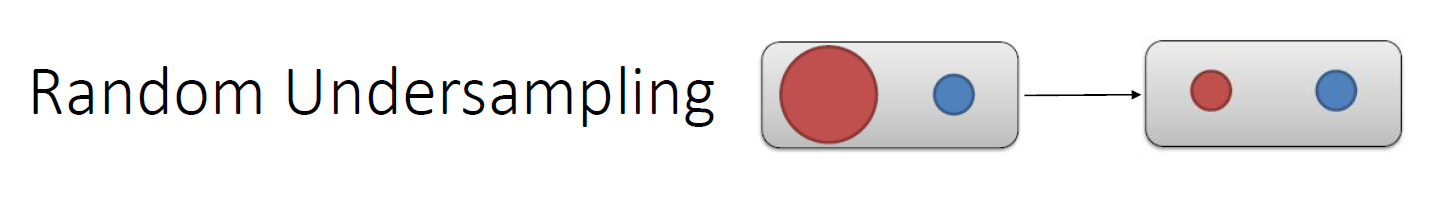

In [19]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_resample(X_train, y_train)

ลองดูจำนวนของ data ที่ทำการ random undersampling จะเห็นว่าข้อมูลชุดที่ออกมาใช้ class 1 data(search_conduct)  and Red is class 0 (seach_conduct not occur) เท่ากัน เป็น balance data คือจำนวนที่ถูกตรวจค้นภายในรถเป็น 14193 คัน และ จำนวนที่ไม่ถูกตรวจค้นภายในรถเป็น 14193 คัน เท่ากันตาม code ที่แสดงข้างล่าง

In [20]:
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

y_train_subsample_unique, y_train_subsample_counts = np.unique(y_train_subsample, return_counts=True)
print(y_train_subsample_counts)

(384467, 31)
(28386, 31)
[14193 14193]
[14193 14193]


## Feature Scaling  


> ทำทั้งในชุด data ที่ imbalance และ balance แล้วเพื่อในตอนสุดท้ายจะนำมาเปรียบเทียบกัน



 

> การทำ Scaling ช่วยเพิ่มประสิทธิภาพให้กับการ train model ได้ การทำการ scaling ทำที่ขั้นตอนหลังจากแยกชุดข้อมูล ระหว่าง test และ train แล้วเพื่อป้องกันการรั่วของข้อมูล หรือ data leakage





> และเช่นเดิม ลอง print ค่าของ X_train, X_test ออกมาดู และ ขนาดของค่าต่างๆ ก็สำคัญ



In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

X_train_subsample = sc.fit_transform(X_train_subsample)



> จะเห็นได้ว่า X_train_subsample ได้เท่ากับ จำนวนที่ทำ random undersampling ไว้แสดงว่าถูกต้อง



In [23]:
print(X_train.shape)
print(X_train_subsample.shape)
print(X_test.shape)

(384467, 31)
(28386, 31)
(96117, 31)


จากขนาดของข้อมูลแต่ละคู่ จะเห็นว่าจำนวน feature ยังเท่าเดิมคือ31 และจำนวน row ยังเท่าเดิมกับก่อนหน้าการทำ scaling ทั้งของ X_train, X_train_subsample และ X_test

In [ ]:
# stop run all with print error
print(ttttt)

## Training model on Logistic Classification, SVC, random forrest, and  XGBOOST classification

Logistic Classification

In [50]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

scores = cross_validate(LogisticRegression(),
                        X_train, y_train, cv=5, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9372009824166326, 0.797715237585076)

Logistic Classification with Random Undersampling (subsample)

In [31]:
scores = cross_validate(LogisticRegression(verbose=1),
                        X_train_subsample, y_train_subsample, cv=5, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(0.9386701127299576, 0.9537929481940459)

SVC with Random Undersampling #use high cost and time, unpractical to use

In [32]:
from sklearn.svm import SVC

scores = cross_validate(SVC(kernel='rbf', verbose=True),
                        X_train_subsample, y_train_subsample, cv=5, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

(0.9071072595579756, 0.9368090289099562)


RandomForrest classification

In [33]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_validate(RandomForestClassifier(n_estimators=100),
                        X_train, y_train, cv=5, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9345992751102754, 0.8013190932881307)

RandomForrest classification with Random Undersampling (subsample)

In [34]:
scores = cross_validate(RandomForestClassifier(n_estimators=100),
                        X_train_subsample, y_train_subsample, cv=5, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9365660720899847, 0.9520531743729025)

XGBOOST classification

In [ ]:
from xgboost import XGBClassifier

scores = cross_validate(XGBClassifier(),
                        X_train, y_train, cv=5, scoring=('roc_auc', 'average_precision'))
# scores = cross_validate(XGBClassifier(learning_rate =0.1,
#                   n_estimators=10,
#                   max_depth=4,
#                   min_child_weight=6,
#                   gamma=0,
#                   subsample=0.8,
#                   colsample_bytree=0.8,
#                   objective= 'binary:logistic',
#                   nthread=4,
#                   scale_pos_weight=1,
#                   seed=27),
#                         X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [24]:
# clear too long output

In [37]:
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9394461386172781, 0.8039781254145721)

XGBOOST classification with Random Undersampling (subsample)

In [ ]:
scores = cross_validate(XGBClassifier(),
                        X_train_subsample, y_train_subsample, cv=5, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [25]:
# clear too long output

In [39]:
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9393616895513006, 0.9543401946226779)

เห็นชัดเจนว่า Random Undersampling ได้ผลดีที่สุดที่ model XGboost Classification

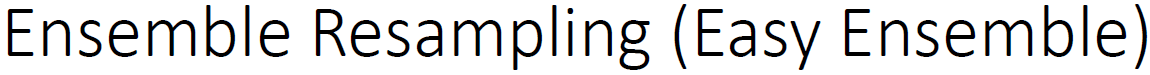

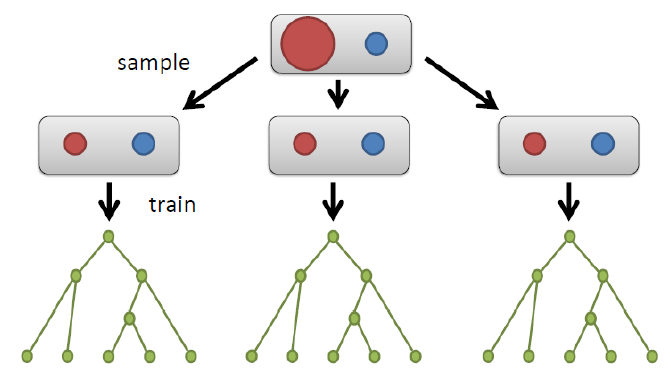

ลองวิธี Ensemble resampling  ด้วย BalanceBaggingClassifier
โดยลองด้วย Randomforest ตามด้วย logistic classifier model  แล้วเช็คดูค่า AUC and AP

เริ่มกันที่ Logistic ก่อน
และต่อด้วย randomforrest และต่อด้วย XGBoost

Logistic Classification with Ensemble resampling (BalanceBagging)

In [41]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier

resampled_lr = BalancedBaggingClassifier(LogisticRegression(),
                                         n_estimators=10, random_state=0)

scores = cross_validate(resampled_lr,
                        X_train, y_train, cv=5, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9384510241440008, 0.7961775169874621)

RandomForrest Classification with Ensemble resampling (BalanceBagging)

In [43]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier

resampled_rf = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='auto'),
                                         random_state=0, n_estimators=10, verbose=1)

In [44]:
scores = cross_validate(resampled_rf,
                        X_train, y_train, cv=5, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

(0.9365463215588076, 0.7952314025178662)

ตอนนี้มีการวัดผลที่ได้ของทั้ง logistic classifier and random forrest ทั้งที่ทำ imbalance และ balance data ด้วยสองวิธี คือ RandomUndersampling และ Ensamble resampling เอามาเทียบกันด้วยการ plot ออกมาเป็น chart จะเห็นได้ชัดเจนกว่าในการเลือก model

In [46]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
lr = LogisticRegression().fit(X_train, y_train)
undersample_pipe = LogisticRegression().fit(X_train_subsample, y_train_subsample)
resampled_lr.fit(X_train, y_train)
lr_crw = LogisticRegression(class_weight="balanced").fit(X_train, y_train)

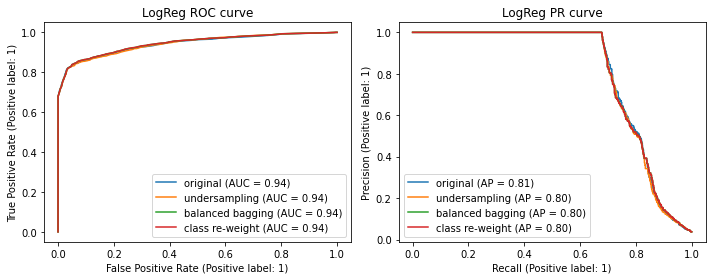

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(lr, X_test, y_test, name="original", ax=axes[0])
# plot_roc_curve(oversample_pipe, X_test, y_test, name="oversampling", ax=axes[0])
plot_roc_curve(undersample_pipe, X_test, y_test, name="undersampling", ax=axes[0])
plot_roc_curve(resampled_lr, X_test, y_test, name="balanced bagging", ax=axes[0])
plot_roc_curve(lr_crw, X_test, y_test, name="class re-weight", ax=axes[0])
axes[0].set_title("LogReg ROC curve")

plot_precision_recall_curve(lr, X_test, y_test, name="original", ax=axes[1])
# plot_precision_recall_curve(oversample_pipe, X_test, y_test, name="oversampling", ax=axes[1])
plot_precision_recall_curve(undersample_pipe, X_test, y_test, name="undersampling", ax=axes[1])
plot_precision_recall_curve(resampled_lr, X_test, y_test, name="balanced bagging", ax=axes[1])
plot_precision_recall_curve(lr_crw, X_test, y_test, name="class re-weight", ax=axes[1])
axes[1].set_title("LogReg PR curve")
plt.tight_layout()

RandomForest ROC curve and PR curve

In [48]:
rf = RandomForestClassifier(random_state=1).fit(X_train, y_train)
rf_crw = RandomForestClassifier(random_state=1, class_weight="balanced").fit(X_train, y_train)
undersample_pipe_rf = RandomForestClassifier(random_state=1).fit(X_train_subsample, y_train_subsample)
resampled_rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='auto'),
                          random_state=0, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


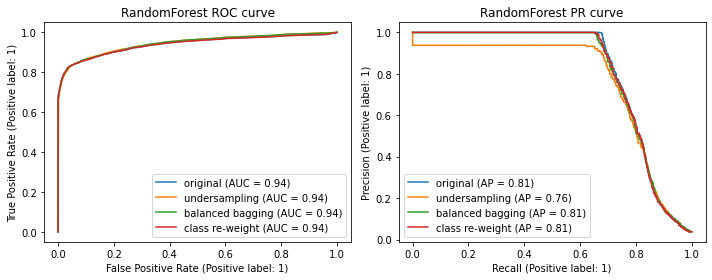

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(rf, X_test, y_test, name="original", ax=axes[0])
plot_roc_curve(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[0])
plot_roc_curve(resampled_rf, X_test, y_test, name="balanced bagging", ax=axes[0])
plot_roc_curve(rf_crw, X_test, y_test, name="class re-weight", ax=axes[0])
axes[0].set_title("RandomForest ROC curve")

plot_precision_recall_curve(rf, X_test, y_test, name="original", ax=axes[1])
plot_precision_recall_curve(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[1])
plot_precision_recall_curve(resampled_rf, X_test, y_test, name="balanced bagging", ax=axes[1])
plot_precision_recall_curve(rf_crw, X_test, y_test, name="class re-weight", ax=axes[1])

axes[1].set_title("RandomForest PR curve")

plt.tight_layout()
#plt.savefig("images/roc_vs_pr.png", dpi=500)

ลองวิธี Ensemble resampling ด้วย BalanceBaggingClassifier โดยลองด้วย XGboost

In [ ]:
resampled_xgb = BalancedBaggingClassifier(XGBClassifier(),
                                         n_estimators=10, random_state=0)

scores = cross_validate(resampled_xgb,
                        X_train, y_train, cv=5, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [54]:
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9394109855022947, 0.803819389069174)

In [ ]:
xgb_t = XGBClassifier().fit(X_train, y_train)
undersample_pipe_xgb = XGBClassifier().fit(X_train_subsample, y_train_subsample)
resampled_xgb.fit(X_train, y_train)
xgb_t_crw50 = XGBClassifier(scale_pos_weight=50).fit(X_train, y_train)
xgb_t_crw99 = XGBClassifier(scale_pos_weight=99).fit(X_train, y_train)

Wall time: 4.33 s


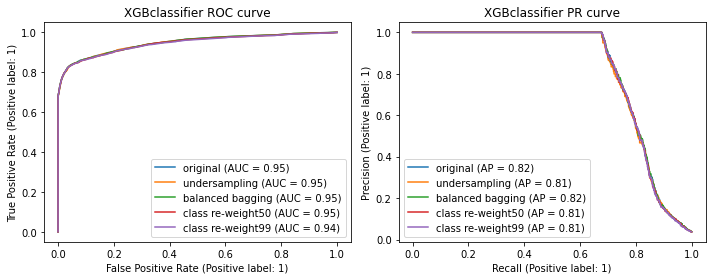

In [58]:
%%time
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(xgb_t, X_test, y_test, name="original", ax=axes[0])
plot_roc_curve(undersample_pipe_xgb, X_test, y_test, name="undersampling", ax=axes[0])
plot_roc_curve(resampled_xgb, X_test, y_test, name="balanced bagging", ax=axes[0])
plot_roc_curve(xgb_t_crw50, X_test, y_test, name="class re-weight50", ax=axes[0])
plot_roc_curve(xgb_t_crw99, X_test, y_test, name="class re-weight99", ax=axes[0])
axes[0].set_title("XGBclassifier ROC curve")

plot_precision_recall_curve(xgb_t, X_test, y_test, name="original", ax=axes[1])
plot_precision_recall_curve(undersample_pipe_xgb, X_test, y_test, name="undersampling", ax=axes[1])
plot_precision_recall_curve(resampled_xgb, X_test, y_test, name="balanced bagging", ax=axes[1])
plot_precision_recall_curve(xgb_t_crw50, X_test, y_test, name="class re-weight50", ax=axes[1])
plot_precision_recall_curve(xgb_t_crw99, X_test, y_test, name="class re-weight99", ax=axes[1])

axes[1].set_title("XGBclassifier PR curve")

plt.tight_layout()
#plt.savefig("images/roc_vs_pr.png", dpi=500)

balance bagging ของ XGBclassifier ทำการ process เป็นเวลานานมาก ถือเป็น cost สูง จึงไม่เหมาะในการนำมาใช้

จาก model rf and xgb ดู มีแนวโน้มที่ดี ต้องลอง imbalance แบบอื่นเทียบ และใช้วิธี balanced bagging ซึ่งค่อนข้าง cost สูงจึงเลือก randomforrest เพื่อไป tune hyperparameter ต่อไป  
ส่วน XGB จะไปทำต่อโดยใช้ original data และ subsample data

Some go further and suggest that using a ROC curve with an imbalanced dataset might be deceptive and lead to incorrect interpretations of the model skill.  
The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets

## Note on Subset data use index selection 


In [ ]:
x = range(20)
list(x)

In [ ]:
list(x[::2])


In [ ]:
list(x[::3])


In [ ]:
list(x[10:40:6])

## Tune Hyperparameter ของ XGboostClassifier 
ด้วย grid search และ random search โดยจะใช้ชุดตัวอย่างจาก Random Undersampling ในการะประหยัด cost ในการ run หา hyperparameter ที่เหมาะสม
และ ใช้ hyperband ช่วยในการ allocate resource เป็นการช่วยให้สามารถทำงานบนเครื่องคอมพิวเตอร์ที่ไม่ได้มี resource สูงมาก และประหยัดเวลากว่า gridsearch และ randomsearch


grid search

In [ ]:
# XGBClassifier(learning_rate =0.1,
#                   n_estimators=10,
#                   max_depth=4,
#                   min_child_weight=6,
#                   gamma=0,
#                   subsample=0.8,
#                   colsample_bytree=0.8,
#                   objective= 'binary:logistic',
#                   nthread=4,
#                   scale_pos_weight=1,
#                   seed=27)

In [59]:
%%time
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

classifier = XGBClassifier()

parameters = {'learning_rate':[0.1,0.2,0.3,0.4],'max_depth':[3,4,5,6,7,8],'colsample_bytree':[0.5,0.6,0.7,0.8,0.9]}

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train_subsample, y_train_subsample)
best_recall = grid_search.best_score_
best_parameters = grid_search.best_params_
print("best_recall: {:.4f} %".format(best_recall*100))
print("Best Parameters:", best_parameters)

C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best_recall: 82.4207 %
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.4, 'max_depth': 4}
Wall time: 9min 4s


In [1]:
from hyperband import HyperbandSearchCV #check hyperband installed

In [28]:
%%time
from hyperband import HyperbandSearchCV
from xgboost import XGBClassifier
# from scipy.stats import randint as sp_randint

model1 = XGBClassifier()
param_dist1 = {
        'learning_rate':[0.1,0.2,0.3,0.4],
        'max_depth': [3,4,5,6,7,8],
        'colsample_bytree':[0.5,0.6,0.7,0.8,0.9]
}
        
search1 = HyperbandSearchCV(model1, param_dist1,
                               resource_param='n_estimators',
                               scoring='roc_auc',
                               n_jobs=-1,
                               cv=10,
                               verbose=0)
search1.fit(X_train_subsample, y_train_subsample)
best_recall_hpb1 = search1.best_score_
best_parameters_hpb1 = search1.best_params_
print("best_recall1: {:.4f} %".format(best_recall_hpb1*100))
print("Best Parameters1:", best_parameters_hpb1)

C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass groups=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is 

[13:50:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best_recall1: 94.0239 %
Best Parameters1: {'max_depth': 8, 'learning_rate': 0.4, 'colsample_bytree': 0.8, 'n_estimators': 9}
Wall time: 2min 3s


In [ ]:
%%time
from hyperband import HyperbandSearchCV
from xgboost import XGBClassifier
# from scipy.stats import randint as sp_randint

model = XGBClassifier()
param_dist = {
        'learning_rate':[0.1,0.2,0.3,0.4],
        'max_depth': [3,4,5,6,7,8],
        'colsample_bytree':[0.5,0.6,0.7,0.8,0.9],
        'objective': ['binary:logistic'] #, 'binary:hinge']
}
        
search = HyperbandSearchCV(model, param_dist,
                               resource_param='n_estimators',
                               scoring='roc_auc',
                               n_jobs=1,
                               cv=10,
                               verbose=0)
search.fit(X_train_subsample, y_train_subsample)
best_recall_hpb = search.best_score_
best_parameters_hpb = search.best_params_
print("best_recall: {:.4f} %".format(best_recall_hpb*100))
print("Best Parameters:", best_parameters_hpb)

In [27]:
best_recall_hpb = search.best_score_
best_parameters_hpb = search.best_params_
print("best_recall: {:.4f} %".format(best_recall_hpb*100))
print("Best Parameters:", best_parameters_hpb)

best_recall: 94.0268 %
Best Parameters: {'objective': 'binary:logistic', 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.5, 'n_estimators': 81}


[13:11:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.  

best_recall: 94.0268 %  
Best Parameters: {'objective': 'binary:logistic', 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.5, 'n_estimators': 81}  
Wall time: 3min 50s

# ทำการ Training the XGboost classification model ด้วย best parameter ที่ได้อีกครั้ง

## Training XGboost classification model on the Training set

### ทำการ fit เพื่อ train model 

XGboost classification with Undersampling (subsample)

In [1]:
from xgboost import XGBClassifier

In [38]:
%%time
from xgboost import XGBClassifier
xgbclassifier = XGBClassifier(learning_rate =0.3,
                n_estimators=81,
                max_depth=4,
                objective='binary:logistic',
                seed=1)
xgbclassifier.fit(X_train_subsample, y_train_subsample)

C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:41:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 535 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=81, n_jobs=12, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

## Predicting a new result on newdriver

### ลองใส่ชุดข้อมูลใหม่จากคนขับใหม่ที่ลองสร้างเองขึ้นมาครับว่า model ของเราใช้งานได้ และ ทำนายออกมาว่าจะโดนตรวจค้นยานพาหนะหรือไม่ และเมื่อสร้างข้อมูลขึ้นมาใหม่ จะต้องทำการ OneHotEncoder กับข้อมูลใหม่นี้ด้วยให้ตรงกับ shape ของการป้อนเข้าไปใส่ให้ model

In [39]:
# ให้ สมมตคนขับรถขึ้นมาหนึ่งคัน โดยมีข้อมูลดังนี้
newdriver = [['X4', 'white', 'female', True, False, False, False, False, False, 'Speeding']]
newdriver_encode = np.array(ct.transform(newdriver))

newdriver_encode

array([[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, True,
        False, False, False, False, False]], dtype=object)

### ต้องทำการ scaling ก่อนเข้า model ด้วย



In [40]:
newdriver_scale = sc.transform(newdriver_encode)
print(newdriver_scale)
print(newdriver_scale.shape)

[[-0.319148   -0.46193944 -0.5764011  -0.13566469 -0.43071592  1.49977104
  -0.14943048 -0.4831943  -0.41111323 -0.04242516  0.7459361   1.95368918
  -1.95368918 -0.05945854 -0.15571664 -0.45986083 -0.05349472 -0.54948242
  -0.27204193 -0.17580136 -0.13753795  1.13056187 -0.05415304 -0.05764108
  -0.02908956  0.5835607  -0.22691212 -0.3937376  -0.12045897 -0.1812641
  -0.59728859]]
(1, 31)


In [41]:
print(xgbclassifier.predict(newdriver_scale))

[0]


In [42]:
xgbclassifier.predict_proba(sc.transform(newdriver_scale))

array([[0.9567637 , 0.04323632]], dtype=float32)

## Predicting the Test set results

### มาลองทดสอบวัดผลของ model โดยใช้ Test set ที่แยกไว้ตั้งแต่แรก ซึ่งเรามีผลลัพธ์ที่เกิดขึ้นจริงมาเปรียบเทียบกับโมเดล ทำให้เราสามารถวัดประสิทธิภาพความแม่นยำ ความเที่ยงตรง และค่าการวัดผลรูปแบบต่างๆ ได้จาก Test set นี้

In [43]:
xgbclassifier.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [44]:
y_pred = xgbclassifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test),1)), axis=1))
print(y_pred.shape)

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]
(96117,)


ตัวแรกคือ predict และ ตัวที่สองคือค่าจริง ที่คนโดนตรวจค้นในรถหรือไม่โดน  
0 คือไม่โดน  
1 คือโดนตรวจค้นรถ

## Making the Confusion Matrix

ใช้ Confusion Matrix มาช่วยในการ evaluation

[[88563  3985]
 [  594  2975]]
accuracy_score : 0.9523601444073369
roc_auc_score : 0.8952540441767592
recall_score : 0.8335668254413001


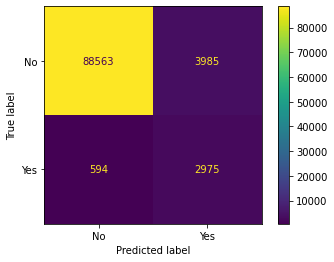

In [45]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, recall_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("accuracy_score :", accuracy_score(y_test, y_pred))
print("roc_auc_score :", roc_auc_score(y_test, y_pred))
print("recall_score :", recall_score(y_test, y_pred))
      
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No','Yes'])
cmd.plot()

หาค่าประสิทธิภาพอื่นๆของ xgbclassification model ของตัวนี้เพิ่มเติม จะเห็นชัดเจนว่า recall ดีขึ้นอย่างมากจาก model เดิมจาก part2 ซึ่งมีค่า racall  0.667

## Visualising the ROC curve
เป็นการวัดประสิทธิภาพที่ดีตัวหนึ่งของ binary classification 

ROC curve ของการตรวจค้นยานพาหนะ เป็นการนำเอา True Positive rate plot with False Positive Rate



In fact, any point on the blue line corresponds to a situation where True Positive Rate is equal to False Positive Rate.

 

All points above this line correspond to the situation where the proportion of correctly classified points belonging to the Positive class is greater than the proportion of incorrectly classified points belonging to the Negative class.

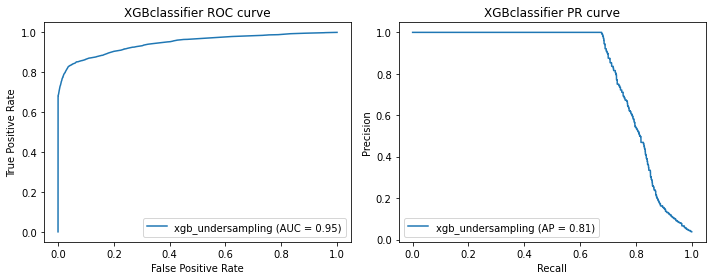

In [49]:
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(xgbclassifier, X_test, y_test, name="xgb_undersampling", ax=axes[0])
# plot_roc_curve(undersample_pipe_xgb, X_test, y_test, name="undersampling", ax=axes[0])
# plot_roc_curve(resampled_xgb, X_test, y_test, name="balanced bagging", ax=axes[0])
# plot_roc_curve(xgb_t_crw50, X_test, y_test, name="class re-weight50", ax=axes[0])
# plot_roc_curve(xgb_t_crw99, X_test, y_test, name="class re-weight99", ax=axes[0])
axes[0].set_title("XGBclassifier ROC curve")

plot_precision_recall_curve(xgbclassifier, X_test, y_test, name="xgb_undersampling", ax=axes[1])
# plot_precision_recall_curve(undersample_pipe_xgb, X_test, y_test, name="undersampling", ax=axes[1])
# plot_precision_recall_curve(resampled_xgb, X_test, y_test, name="balanced bagging", ax=axes[1])
# plot_precision_recall_curve(xgb_t_crw50, X_test, y_test, name="class re-weight50", ax=axes[1])
# plot_precision_recall_curve(xgb_t_crw99, X_test, y_test, name="class re-weight99", ax=axes[1])

axes[1].set_title("XGBclassifier PR curve")

plt.tight_layout()

##  Display classification performance metrics

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Performance:")
print(" >accuracy = " + str(accuracy))
print(" >precision = " + str(precision))
print(" >recall = " + str(recall))
print(" >f1-score = " + str(f1))


Performance:
 >accuracy = 0.9523601444073369
 >precision = 0.4274425287356322
 >recall = 0.8335668254413001
 >f1-score = 0.5651058979960111


ตัวโมเดล จะสนใจที่ recall และ PR curve เป็นหลักสำคัญซึ่ง ได้ค่าที่สุดตาม best_parameters ที่ได้ปรับจูนแล้ว  ซึ่งสามารถวัดค่าความสามารถในการทำนายได้ดีกว่า การทำ model ของบทความนี้ใน part2 อย่างมีนัยสำคัญ
หากดูเส้นกราฟนี้แล้วจะสามารถพิจารณาได้ว่าผลการทำนายของเรานั้นดีแค่ไหนโดยทั่วไปจะถือว่าหากกราฟยิ่ง ชิดด้านบนขวาของ PR curve มากก็ยิ่งแปลว่าทำนายได้ดี แต่หากกราฟเป็นเส้นตรงจะแสดงว่าไม่ดี 

หมายความว่า ยิ่งเส้นใน PR curve chart ใกล้ไปข้างบนขวามากเท่าไหร่ก็แสดงว่า model ของเรา ทำการแยกแยะ ได้อย่างถูกต้องกว่า เช่น สมมติว่า มีของผิด กฏหมายในรถ ถ้าทำนายว่าโดนตรวจค้นแน่ๆ ก็จะกลัวก็อาจจะไม่ขับรถวันนี้ แต่ถ้า ทำนายว่าไม่โดนจับแน่แต่ทำนายผิด สุดท้ายแล้วเป็นความหวังที่คิดว่าไม่โดนตรวจค้น พอไปขับรถจริงโดนเรียกตรวจค้นก็เจอสิ่งผิดกฏหมายในรถ False Negative เป็น error type2
    ส่วนนี้เองคือ sensitivity หรือ recall นั่นเอง ถ้าค่า recall ต่ำจะเกิด False Negative เยอะทำให้การที่ทำนายว่า รถคันนี้จะไม่ถูกตรวจแต่สุดท้ายจะโดนตำรวจทำการตรวจค้น  
    
    

XGboost classification original data (imbalance data)

In [51]:
%%time
from xgboost import XGBClassifier
xgbclassifier1 = XGBClassifier(learning_rate =0.3,
                n_estimators=81,
                max_depth=4,
                objective='binary:logistic',
                seed=1)
xgbclassifier1.fit(X_train, y_train)

C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5.83 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=81, n_jobs=12, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [52]:
y_pred1 = xgbclassifier1.predict(X_test)
print(np.concatenate((y_pred1.reshape(len(y_pred1), 1), y_test.reshape(len(y_test),1)), axis=1))
print(y_pred1.shape)

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]
(96117,)


[[92548     0]
 [ 1150  2419]]
accuracy_score : 0.9880354151710936
roc_auc_score : 0.838890445502942
recall_score : 0.677780891005884


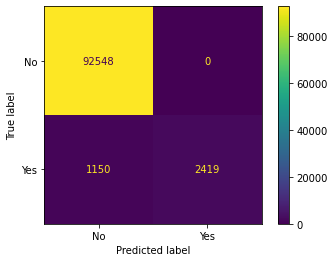

In [53]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, recall_score
cm1 = confusion_matrix(y_test, y_pred1)
print(cm1)
print("accuracy_score :", accuracy_score(y_test, y_pred1))
print("roc_auc_score :", roc_auc_score(y_test, y_pred1))
print("recall_score :", recall_score(y_test, y_pred1))
      
cmd1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['No','Yes'])
cmd1.plot()

แสดงว่า ต้องทำการ balance ข้อมูลก่อนมาทำการ fit model ไม่งั้น recall น้อยกว่า ซึ่งไม่ดีนั่นเอง

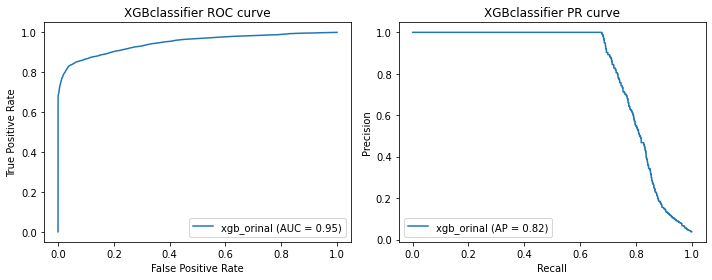

In [57]:
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(xgbclassifier1, X_test, y_test, name="xgb_orinal", ax=axes[0])
# plot_roc_curve(undersample_pipe_xgb, X_test, y_test, name="undersampling", ax=axes[0])
# plot_roc_curve(resampled_xgb, X_test, y_test, name="balanced bagging", ax=axes[0])
# plot_roc_curve(xgb_t_crw50, X_test, y_test, name="class re-weight50", ax=axes[0])
# plot_roc_curve(xgb_t_crw99, X_test, y_test, name="class re-weight99", ax=axes[0])
axes[0].set_title("XGBclassifier ROC curve")

plot_precision_recall_curve(xgbclassifier1, X_test, y_test, name="xgb_orinal", ax=axes[1])
# plot_precision_recall_curve(undersample_pipe_xgb, X_test, y_test, name="undersampling", ax=axes[1])
# plot_precision_recall_curve(resampled_xgb, X_test, y_test, name="balanced bagging", ax=axes[1])
# plot_precision_recall_curve(xgb_t_crw50, X_test, y_test, name="class re-weight50", ax=axes[1])
# plot_precision_recall_curve(xgb_t_crw99, X_test, y_test, name="class re-weight99", ax=axes[1])

axes[1].set_title("XGBclassifier PR curve")

plt.tight_layout()

## ลอง rasampling ดู

XGboost classification Ensemble resampling

In [54]:
%%time
from imblearn.ensemble import BalancedBaggingClassifier
# from sklearn.model_selection import cross_validate

resampled_xgb1 = BalancedBaggingClassifier(XGBClassifier(learning_rate =0.3,
                        n_estimators=81,
                        max_depth=4,
                        objective='binary:logistic',
                        seed=1),
                        n_estimators=10, random_state=0)
resampled_xgb1.fit(X_train, y_train)
# scores = cross_validate(resampled_xgb,
#                         X_train, y_train, cv=5, scoring=('roc_auc', 'average_precision'))
# scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:07:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\t_tan\anaconda3\envs\tf2.4\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:07:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8.31 s


BalancedBaggingClassifier(base_estimator=XGBClassifier(base_score=None,
                                                       booster=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       gamma=None, gpu_id=None,
                                                       importance_type='gain',
                                                       interaction_constraints=None,
                                                       learning_rate=0.3,
                                                       max_delta_step=None,
                                                       max_depth=4,
                                                       min_child_weight=None,
                                                       missing=nan,
                

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]
(96117,)
[[88680  3868]
 [  593  2976]]
accuracy_score : 0.9535878148506508
roc_auc_score : 0.8960262438630288
recall_score : 0.8338470159708602


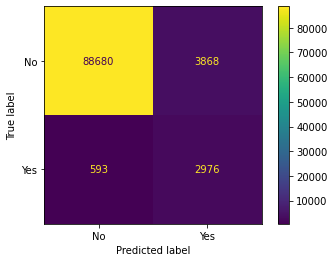

In [55]:
y_pred2 = resampled_xgb1.predict(X_test)
print(np.concatenate((y_pred2.reshape(len(y_pred2), 1), y_test.reshape(len(y_test),1)), axis=1))
print(y_pred2.shape)

%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, recall_score
cm2 = confusion_matrix(y_test, y_pred2)
print(cm2)
print("accuracy_score :", accuracy_score(y_test, y_pred2))
print("roc_auc_score :", roc_auc_score(y_test, y_pred2))
print("recall_score :", recall_score(y_test, y_pred2))
      
cmd2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['No','Yes'])
cmd2.plot()

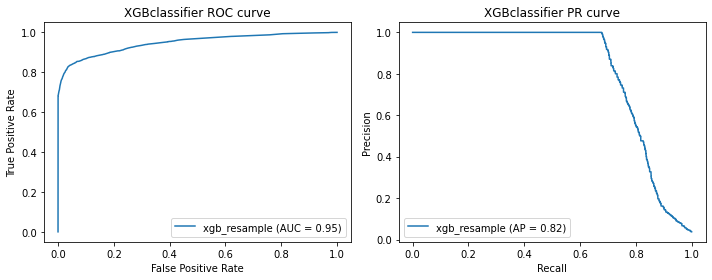

In [56]:
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_roc_curve(resampled_xgb1, X_test, y_test, name="xgb_resample", ax=axes[0])

# plot_roc_curve(resampled_xgb, X_test, y_test, name="balanced bagging", ax=axes[0])
# plot_roc_curve(xgb_t_crw50, X_test, y_test, name="class re-weight50", ax=axes[0])
# plot_roc_curve(xgb_t_crw99, X_test, y_test, name="class re-weight99", ax=axes[0])
axes[0].set_title("XGBclassifier ROC curve")

plot_precision_recall_curve(resampled_xgb1, X_test, y_test, name="xgb_resample", ax=axes[1])
# plot_precision_recall_curve(undersample_pipe_xgb, X_test, y_test, name="undersampling", ax=axes[1])
# plot_precision_recall_curve(resampled_xgb, X_test, y_test, name="balanced bagging", ax=axes[1])
# plot_precision_recall_curve(xgb_t_crw50, X_test, y_test, name="class re-weight50", ax=axes[1])
# plot_precision_recall_curve(xgb_t_crw99, X_test, y_test, name="class re-weight99", ax=axes[1])

axes[1].set_title("XGBclassifier PR curve")

plt.tight_layout()

Comparison XGBclassifier on original data(imbalance) and balanced data

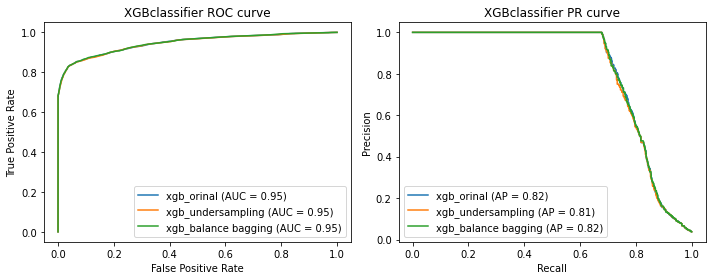

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(xgbclassifier1, X_test, y_test, name="xgb_orinal", ax=axes[0])
plot_roc_curve(xgbclassifier, X_test, y_test, name="xgb_undersampling", ax=axes[0])
plot_roc_curve(resampled_xgb1, X_test, y_test, name="xgb_balance bagging", ax=axes[0])

axes[0].set_title("XGBclassifier ROC curve")
plot_precision_recall_curve(xgbclassifier1, X_test, y_test, name="xgb_orinal", ax=axes[1])
plot_precision_recall_curve(xgbclassifier, X_test, y_test, name="xgb_undersampling", ax=axes[1])
plot_precision_recall_curve(resampled_xgb1, X_test, y_test, name="xgb_balance bagging", ax=axes[1])

axes[1].set_title("XGBclassifier PR curve")

plt.tight_layout()

balance bagging ดีสุด ทั้ง AP , PR curve , ค่า recall

xgb_original recall_score : 0.677780891005884  
xgb_undersampling recall_score : 0.8335668254413001  
xgb_balance bagging recall_score : 0.8338470159708602  